LSR-REQ-0095-V-01: Bright Sources Relative to Nominal Saturation Limit

In [65]:
from lsst.daf.butler import Butler
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from lsst.summit.utils import ConsDbClient
from lsst.afw.table import SimpleCatalog
import pandas as pd
from smatch import match

# Identify short visits during twilight 
We want to look at exposure times from the lsstcomcam.exposure database https://sdm-schemas.lsst.io/cdb_lsstcomcam.html 

In [2]:
os.environ["no_proxy"] += ",.consdb" 
client = ConsDbClient("http://consdb-pq.consdb:8080/consdb")
print(client.schema())

['latiss', 'lsstcam', 'lsstcamsim', 'lsstcomcam', 'lsstcomcamsim', 'startrackerfast', 'startrackernarrow', 'startrackerwide']


In [3]:
instrument = 'lsstcomcam'
    
# visits_query = f'''
#     SELECT visit.*, exp.* 
#     FROM cdb_{instrument}.exposure as exp, cdb_{instrument}.visit1_qucklook
#     JOINON exp.exposure_id = visit.exposure_id
#     WHERE exp.exp_time < 15
#     AND exp.exp_time > 1
#     AND exp.day_obs > 20241201
#     AND exp.img_type NOT in ('BIAS', 'DARK', 'ENGTEST', 'FLAT', 'STUTTERED', 'FOCUS', 'CWFS')
# '''
visits_query = f'''
    SELECT exp.* 
    FROM cdb_{instrument}.exposure AS exp
    WHERE exp.exp_time < 15
    AND exp.exp_time > 1
    AND exp.day_obs > 20241201
    AND exp.img_type NOT IN ('BIAS', 'DARK', 'ENGTEST', 'FLAT', 'STUTTERED', 'FOCUS', 'CWFS')
'''
#AND target_name = 'EDFS_comcam'

visits = client.query(visits_query).to_pandas()
# see if we should include flats

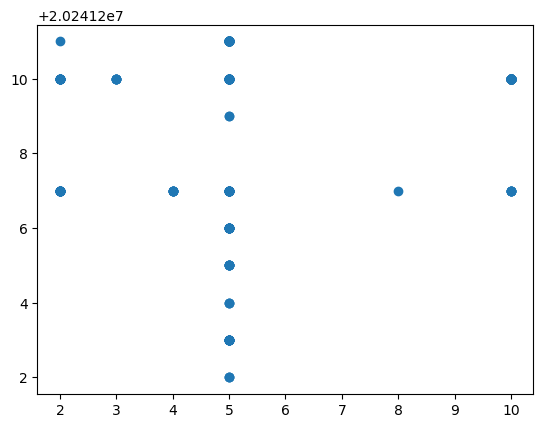

In [4]:
plt.scatter(visits["exp_time"], visits['day_obs'])

In [5]:
str1="("
for i in list(visits['exposure_id'].values):
    str1 += str(i) + ","
str1+=")"

In [21]:
repo = '/repo/main'

butler = Butler(repo, collections=['u/pferguso/LVV-243/calibrateImage'])

registry= butler.registry

all_collections = registry.queryCollections()
collections =[]



In [22]:
dataId={'visit': 2024120500012, 'instrument':'LSSTComCam'}

In [23]:
all_collections=[ i for i in all_collections]# if ("LSSTComCam" in i) or ("raws" in i)]
refs=sorted(butler.registry.queryDatasets('preSource', 
                                          collections=['u/pferguso/LVV-243/calibrateImage'], 
                                          where="instrument = 'LSSTComCam'"))#, )) , dataId=dataId

In [28]:
preSource_visit_list = [ref.dataId['visit'] for ref in refs]
exptime_list = [visits['exp_time'][visits['exposure_id'] == i].values[0] for i in preSource_visit_list]

(array([  9.,   0.,   0., 266.,   0.,   0.,   0.,   0.,   0.,  18.]),
 array([ 2. ,  2.8,  3.6,  4.4,  5.2,  6. ,  6.8,  7.6,  8.4,  9.2, 10. ]),
 <BarContainer object of 10 artists>)

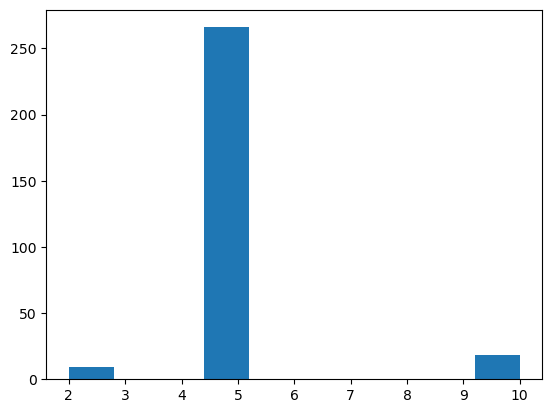

In [30]:
plt.hist(exptime_list)

In [45]:
def convert_to_mag(flux):
    flux = np.asarray(flux)
    return (flux * u.nJy).to(u.ABmag).value

In [57]:
monster_refs=None
for ref in refs:
    if monster_refs is None:
        monster_refs = butler.query_datasets('the_monster_20240904', data_id=ref.dataId)
    else:
        monster_refs += butler.query_datasets('the_monster_20240904', data_id=ref.dataId)
monster_refs = np.unique(monster_refs)
ref_cat=None
for ref in monster_refs:
    if ref_cat == None:
        tmp = butler.get(ref)
        ref_cat = SimpleCatalog(tmp.schema)
        ref_cat.extend(tmp)
    else: 
        ref_cat.extend(butler.get(ref))


In [59]:
ref_cols = ['coord_ra','coord_dec']
for band in "ugrizy":
    ref_cols.append(f"monster_SynthLSST_{band}_flux")

ref_cat_frame = pd.DataFrame({col:ref_cat[col] for col in ref_cols})

for band in "ugrizy":
    ref_cat_frame[f'monster_{band}_mag']= convert_to_mag(ref_cat[f"monster_SynthLSST_{band}_flux"])


In [90]:
catalog_dict = {5.0:{}, 2.0:{}, 10.0:{}}
for ref in refs:
    visit = ref.dataId['visit']
    exptime = visits['exp_time'][visits['exposure_id'] == ref.dataId['visit']].values[0]
    if len(catalog_dict[exptime]) <= 3:
        print(exptime, visit)
        catalog = butler.get('preSource', dataId=ref.dataId)
        sel = (catalog['base_PsfFlux_flux'] / catalog['base_PsfFlux_fluxErr'] > 50)
        catalog = catalog[sel]
        result=match(ra1=np.rad2deg(catalog["coord_ra"]), 
              dec1=np.rad2deg(catalog['coord_dec']), 
              ra2=np.degrees(ref_cat_frame['coord_ra']), 
              dec2=np.degrees(ref_cat_frame['coord_dec']), 
              radius1=0.25)
        catalog_dict[exptime][visit]={}
        catalog_dict[exptime][visit]['catalog']= catalog
        catalog_dict[exptime][visit]['match']= result

5.0 2024120300014
5.0 2024120300028
5.0 2024120300188
5.0 2024120300203
10.0 2024120700549
10.0 2024120700550
2.0 2024121100482
10.0 2024120700549
10.0 2024120700550
2.0 2024121100482
10.0 2024120700549
10.0 2024120700550
2.0 2024121100482
10.0 2024120700549
10.0 2024120700550
2.0 2024121100482
10.0 2024120700549
10.0 2024120700550
2.0 2024121100482
10.0 2024120700549
10.0 2024120700550
2.0 2024121100482
10.0 2024120700549
10.0 2024120700550
2.0 2024121100482
10.0 2024120700549
10.0 2024120700550
2.0 2024121100482
10.0 2024120700549
10.0 2024120700550
2.0 2024121100482


In [91]:
for key in catalog_dict.keys():
    for key2 in catalog_dict[key].keys():
        print(catalog_dict[key][key2]['match'])
#catalog_dict[exptime][visit][f"match"]

[( 0, 412497, 1.        ) ( 1, 412563, 1.        )
 ( 2, 412573, 0.99999998) ( 3, 414021, 1.        )
 ( 4, 412573, 1.        ) ( 5, 414020, 1.        )
 ( 6, 412574, 1.        ) ( 7, 412520, 1.        )
 ( 8, 412494, 1.        ) ( 9, 412557, 1.        )
 (10, 412562, 1.        ) (11, 412515, 1.        )
 (12, 412490, 1.        ) (13, 412559, 1.        )
 (14, 412555, 1.        ) (15, 412491, 1.        )
 (16, 412498, 0.99999999) (17, 412572, 1.        )
 (18, 412514, 1.        ) (19, 412513, 1.        )
 (20, 414019, 1.        ) (21, 412556, 1.        )
 (22, 412558, 0.99999999) (23, 412558, 1.        )
 (24, 414059, 1.        ) (25, 412469, 1.        )
 (26, 412551, 1.        ) (27, 412464, 1.        )
 (28, 412485, 1.        ) (29, 414011, 1.        )
 (30, 412487, 1.        ) (31, 412470, 1.        )
 (32, 412486, 1.        ) (33, 412471, 1.        )
 (34, 412545, 1.        ) (35, 414016, 1.        )
 (36, 412539, 1.        ) (37, 412548, 1.        )
 (38, 412478, 1.        ) (39, 

In [94]:
ref_cat_frame.iloc[ref_sel]

,coord_ra,coord_dec,monster_SynthLSST_u_flux,monster_SynthLSST_g_flux,monster_SynthLSST_r_flux,monster_SynthLSST_i_flux,monster_SynthLSST_z_flux,monster_SynthLSST_y_flux,monster_u_mag,monster_g_mag,monster_r_mag,monster_i_mag,monster_z_mag,monster_y_mag
399328,1.117218,-0.586456,NaN,1.444979e+05,4.219445e+05,6.106539e+05,7.492372e+05,7.487867e+05,NaN,18.500346,17.336862,16.935512,16.713452,16.714105
399333,1.117412,-0.585797,NaN,9.004533e+04,2.975343e+05,6.754985e+05,9.990984e+05,1.125091e+06,NaN,19.013847,17.716157,16.825939,16.400979,16.272031
399661,1.117466,-0.584383,NaN,3.155037e+05,6.677728e+05,8.263137e+05,9.197629e+05,8.876851e+05,NaN,17.652489,16.838428,16.607138,16.490810,16.529353
399322,1.117583,-0.587060,NaN,1.440546e+05,4.228317e+05,6.168757e+05,7.641069e+05,7.708316e+05,NaN,18.503682,17.334581,16.924506,16.692115,16.682601
399262,1.117658,-0.587176,1.578304e+05,8.038318e+05,1.491532e+06,1.755463e+06,1.880285e+06,1.774793e+06,18.404524,16.637087,15.965919,15.789021,15.714441,15.777131
399651,1.117766,-0.585061,NaN,3.986637e+05,1.292371e+06,2.174284e+06,2.895820e+06,3.021810e+06,NaN,17.398483,16.121532,15.556709,15.245571,15.199332
399663,1.117809,-0.584209,NaN,5.495736e+04,1.939867e+05,6.584175e+05,1.181726e+06,1.369235e+06,NaN,19.549935,18.180570,16.853747,16.218708,16.058805
399325,1.117874,-0.586715,NaN,5.266348e+04,1.161490e+05,1.503053e+05,1.719323e+05,1.673309e+05,NaN,19.596226,18.737462,18.457564,18.311606,18.341059
399264,1.117980,-0.586860,5.541175e+05,1.867626e+06,2.909403e+06,3.250950e+06,3.334282e+06,2.915331e+06,17.040995,15.721775,15.240490,15.119974,15.092494,15.238280
399666,1.118022,-0.584127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [98]:
visits['band'][visits['exposure_id']==visit].

'r'

[(13.0, 20.0),
 (-0.2, 0.2),
 Text(0.5, 0, 'monster_SynthLSST_{band}_mag'),
 Text(0, 0.5, 'r_psfFlux/monster_SynthLSST_{band}_flux')]

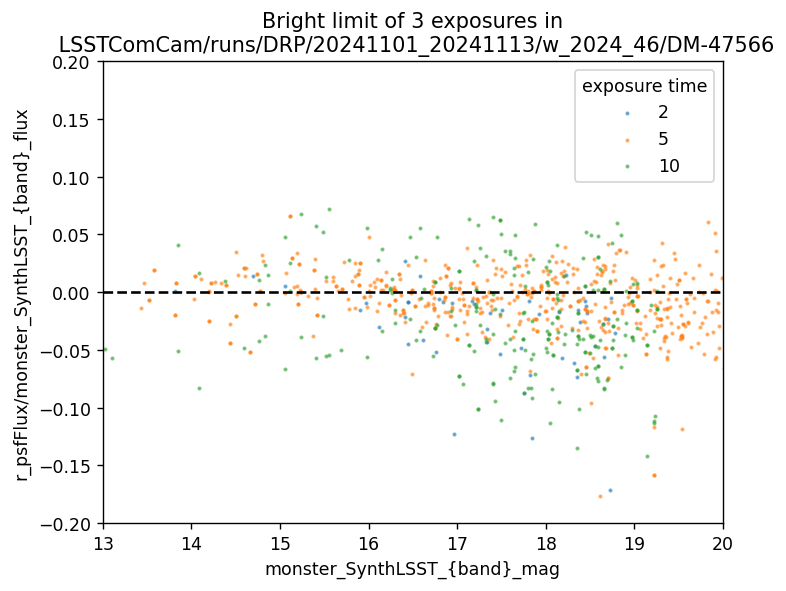

In [111]:
fig, ax= plt.subplots(1, dpi=125)
clist=["tab:blue","tab:orange","tab:green"]
ax.set_title("Bright limit of 3 exposures in\n LSSTComCam/runs/DRP/20241101_20241113/w_2024_46/DM-47566")
for i,exptime in enumerate([2,5,10]):
    for visit in catalog_dict[exptime]:
        ref_sel = catalog_dict[exptime][visit][f"match"]['i2']
        catalog = catalog_dict[exptime][visit]['catalog']
        band = visits['band'][visits['exposure_id']==visit].values[0]
        #st_sel = bs_dict[f"match_{exptime}"]['i1']
        ax.scatter(ref_cat_frame.iloc[ref_sel][f'monster_{band}_mag'], 
                   convert_to_mag(catalog['base_PsfFlux_flux'].values) - ref_cat_frame.iloc[ref_sel][f'monster_{band}_mag'], 
                   #label=f"{exptime} s visit bright_lim={bs_dict[f'bright_val_{exptime}']:0.1f}", 
                   label=exptime,
                   s=2, c=clist[i], alpha=0.5)
        #medians=medfilt(bs_dict[f'st_{exptime}']['psfFlux'].values[st_sel]/ref_cat_flux[ref_sel], 21)
        #ax.plot(ref_cat_mag[ref_sel], medians, c=clist[i])
        #ax.axvline(bs_dict[f"bright_val_{exptime}"], ls="dashed", c=clist[i])
ax.axhline(0, c="k", ls="dashed")
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
plt.legend(unique_labels.values(), unique_labels.keys(), title="exposure time")
ax.set(xlim=(13,20), ylim=(-.2,0.2), xlabel="monster_SynthLSST_{band}_mag", ylabel="r_psfFlux/monster_SynthLSST_{band}_flux")


In [9]:
len(refs)

293

In [15]:
dat=butler.get(refs[0])

In [14]:
refs[0].dataId['visit']

2024120300014

In [16]:
dat

,id,coord_ra,coord_dec,parent,calib_psf_candidate,calib_psf_used,calib_psf_reserved,apcorr_slot_CalibFlux_used,apcorr_base_GaussianFlux_used,apcorr_base_PsfFlux_used,...,base_PsfFlux_flux,slot_PsfFlux_flux,base_PsfFlux_mag,slot_PsfFlux_mag,base_PsfFlux_fluxErr,slot_PsfFlux_fluxErr,base_PsfFlux_magErr,slot_PsfFlux_magErr,deblend_psf_flux,deblend_psf_mag
0,191790036952285198,0.872985,-0.496226,0,False,False,False,False,False,False,...,6.060089e+03,6.060089e+03,21.943802,21.943802,601.549580,601.549580,0.107775,0.107775,NaN,NaN
1,191790036952285199,0.874147,-0.497045,0,False,False,False,False,False,False,...,3.386092e+05,3.386092e+05,17.575753,17.575753,1513.839903,1513.839903,0.004854,0.004854,NaN,NaN
2,191790036952285201,0.873942,-0.496892,0,False,False,False,False,False,False,...,4.059633e+03,4.059633e+03,22.378783,22.378783,580.721677,580.721677,0.155312,0.155312,NaN,NaN
3,191790036952285202,0.873645,-0.496669,0,False,False,False,False,False,False,...,5.151752e+04,5.151752e+04,19.620113,19.620113,787.414181,787.414181,0.016595,0.016595,NaN,NaN
4,191790036952285203,0.874331,-0.497152,0,False,False,False,False,False,False,...,5.072690e+03,5.072690e+03,22.136904,22.136904,568.931826,568.931826,0.121772,0.121772,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1167,191790036952286591,0.875127,-0.493054,191790036952286198,True,True,False,False,True,True,...,5.829207e+06,5.829207e+06,14.485976,14.485976,6429.359930,6429.359930,0.001198,0.001198,NaN,NaN
1168,191790036952286596,0.873895,-0.492142,191790036952286213,False,False,False,False,False,False,...,2.638657e+03,2.638657e+03,22.846543,22.846543,472.649777,472.649777,0.194483,0.194483,1857.924493,23.227430
1169,191790036952286597,0.873892,-0.492137,191790036952286213,False,False,False,False,False,False,...,2.274830e+03,2.274830e+03,23.007628,23.007628,469.068739,469.068739,0.223878,0.223878,1266.038548,23.643883
1170,191790036952286598,0.874548,-0.492491,191790036952286232,False,False,False,False,False,False,...,1.771121e+04,1.771121e+04,20.779379,20.779379,575.346335,575.346335,0.035270,0.035270,14747.099262,20.978233


(array([  3.,  14.,   3.,   7.,  14.,  58.,   0.,   2., 150.,  50.]),
 array([1202. , 1202.9, 1203.8, 1204.7, 1205.6, 1206.5, 1207.4, 1208.3,
        1209.2, 1210.1, 1211. ]),
 <BarContainer object of 10 artists>)

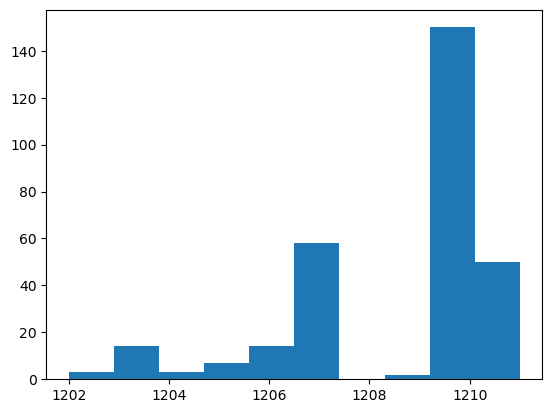

In [17]:
plt.hist(visits['day_obs']-20240000)

In [16]:
np.unique(visits['img_type'])

array(['ACQ', 'CWFS', 'FOCUS', 'OBJECT'], dtype=object)

In [9]:
visits.iloc[:,-20:-10]

,dark_time,group_id,cur_index,max_index,img_type,emulated,science_program,observation_reason,target_name,air_temp
0,0.015316,2024-07-10T17:16:01.744,1,1,BIAS,False,None,None,,0.025
1,0.013002,2024-07-10T17:16:01.744,1,1,BIAS,False,None,None,,0.025
2,0.014171,2024-07-10T17:16:01.744,1,1,BIAS,False,None,None,,0.025
3,0.013132,2024-07-10T17:16:01.744,1,1,BIAS,False,None,None,,0.025
4,0.012473,2024-07-10T17:16:01.744,1,1,BIAS,False,None,None,,0.025
...,...,...,...,...,...,...,...,...,...,...
5770,81.921321,2024-12-12T07:36:06.939,2,1,STUTTERED,False,BLOCK-T346,None,,12.425
5771,81.869447,2024-12-12T07:37:43.289,2,1,STUTTERED,False,BLOCK-T346,None,,12.300
5772,81.866138,2024-12-12T07:43:44.514,2,1,STUTTERED,False,BLOCK-T346,None,,12.425
5773,5.439541,2024-12-12T07:45:47.180,1,1,ACQ,False,BLOCK-T311,focus_check,slew_icrs,12.300
